# CS 282
### Programming Assignment 2

Jan Lendl R. Uy

2019-00312

#### Sytem Specifications
- macOS Sequoia 15.0.1
- Macbook Air M1 (ARM), 8-Core CPU and 8-Core GPU

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Step 1
Load images tower_left.jpg and tower_right.jpg and convert to double and to grayscale.

In [3]:
tower_left = cv2.imread("images/tower_left.jpg", cv2.IMREAD_GRAYSCALE)
tower_right = cv2.imread("images/tower_right.jpg", cv2.IMREAD_GRAYSCALE)

# Convert to float
tower_left = cv2.convertScaleAbs(tower_left, cv2.CV_64F)
tower_right = cv2.convertScaleAbs(tower_right, cv2.CV_64F)

### Step 2
Detect feature points in both images using a Harris Detector

In [ ]:
# Tower Left

# Get Harris response with parameters:
# blockSize=2
# ksize=3
# k=0.04
response_tower_left = cv2.cornerHarris(
    tower_left, 
    blockSize=2,
    ksize=3,
    k=0.04
)

# Perform thresholding at 1% of max value of the Harris response
threshold_ratio = 0.01
threshold_tower_left = threshold_ratio * response_tower_left.max()
corners_tower_left = np.where(response_tower_left > threshold_tower_left)
corners_tower_left = np.array(list(zip(corners_tower_left[1], corners_tower_left[0])))  # (x, y) format

In [ ]:
# Tower Right

# Get Harris response
# blockSize=2
# ksize=3
# k=0.04
response_tower_right = cv2.cornerHarris(
    tower_right, 
    blockSize=2,
    ksize=3,
    k=0.04
)

# Perform thresholding at 1% of max value of the Harris response
threshold_ratio = 0.01
threshold_tower_right = threshold_ratio * response_tower_right.max()
corners_tower_right = np.where(response_tower_right > threshold_tower_right)
corners_tower_right = np.array(list(zip(corners_tower_right[1], corners_tower_right[0])))  # (x, y) format

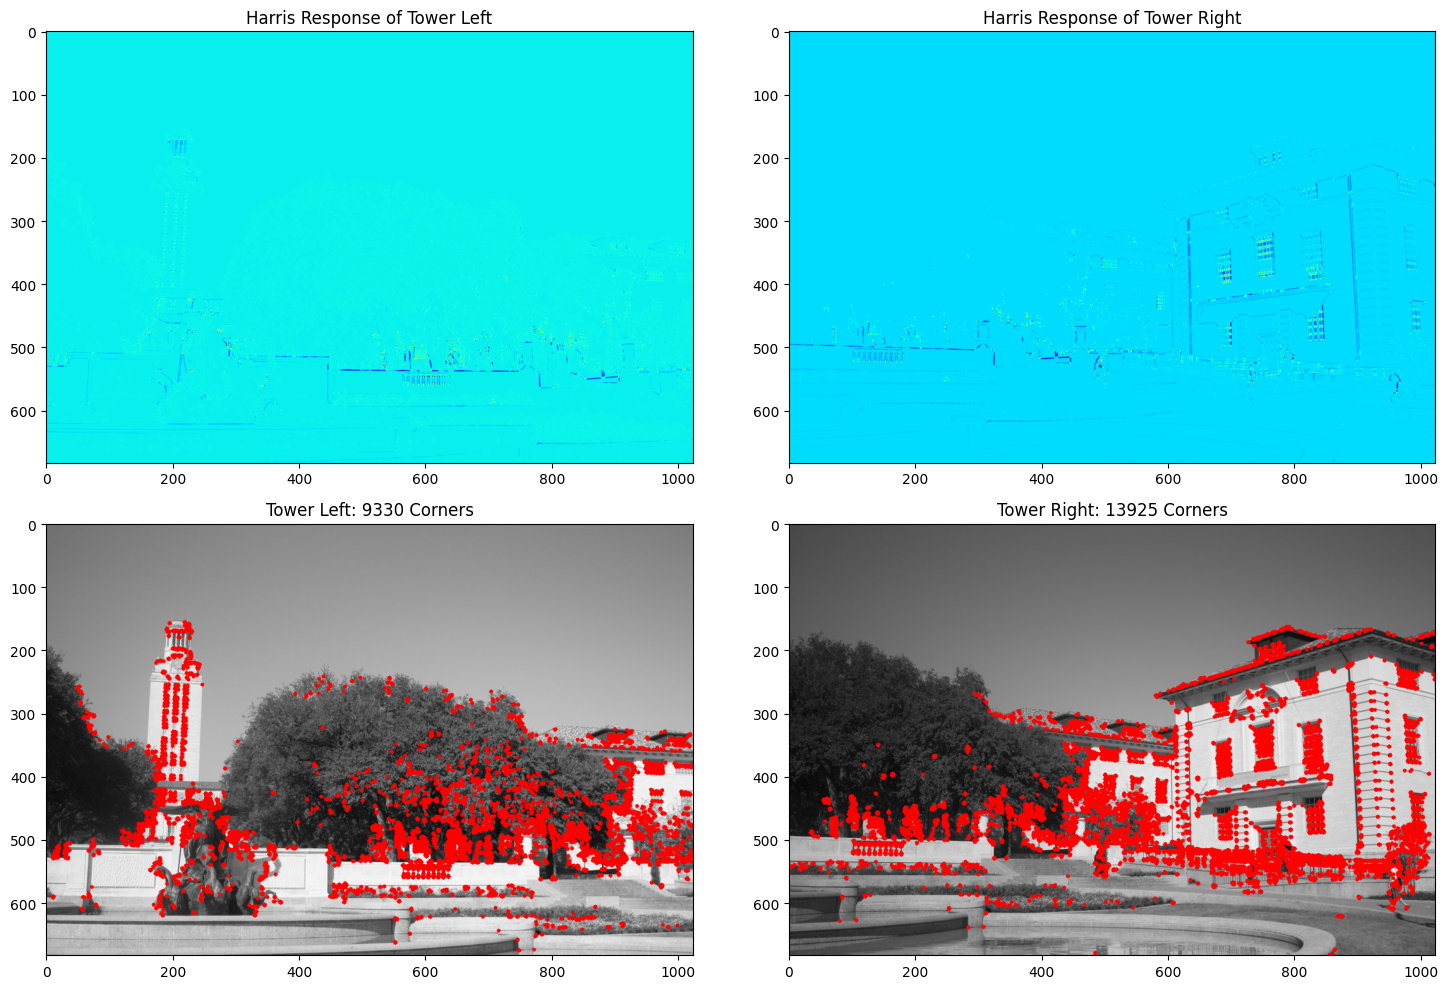

Detected 9330 corners in the left image
Detected 13925 corners in the right image


In [6]:
# Visualize the detected corners on the left image
left_with_corners = cv2.cvtColor(tower_left, cv2.COLOR_GRAY2BGR)
for x, y in corners_tower_left:
    cv2.circle(left_with_corners, (x, y), 3, (0, 0, 255), -1)

# Visualize the detected corners on the right image
right_with_corners = cv2.cvtColor(tower_right, cv2.COLOR_GRAY2BGR)
for x, y in corners_tower_right:
    cv2.circle(right_with_corners, (x, y), 3, (0, 0, 255), -1)

# Display the results
plt.figure(figsize=(15, 10))
plt.subplot(221), plt.imshow(response_tower_left, cmap="jet"), plt.title("Harris Response of Tower Left")
plt.subplot(222), plt.imshow(response_tower_right, cmap="jet"), plt.title("Harris Response of Tower Right")
plt.subplot(223), plt.imshow(cv2.cvtColor(left_with_corners, cv2.COLOR_BGR2RGB)), plt.title(f"Tower Left: {len(corners_tower_left)} Corners")
plt.subplot(224), plt.imshow(cv2.cvtColor(right_with_corners, cv2.COLOR_BGR2RGB)), plt.title(f"Tower Right: {len(corners_tower_right)} Corners")
plt.tight_layout()
plt.show()

print(f"Detected {len(corners_tower_left)} corners in the left image")
print(f"Detected {len(corners_tower_right)} corners in the right image")

### Step 3
Extract fixed-size patches around every keypoint in both images, and form descriptors simply by ”flattening” the pixel values in each patch to one-dimensional vectors. Experiment with different patch sizes to see which one works best.

In [ ]:
# A patch size of 14x14 resulted in the best inlier points in 
# the succeeding steps
patch_size = 14
half_size = patch_size // 2
h_left, w_left = tower_left.shape
h_right, w_right = tower_right.shape

In [8]:
# Extract descriptors for the left image
descriptors_left = []
valid_corners_left = []
for x, y in corners_tower_left:
    # Check if patch is fully within the image
    if (x - half_size >= 0 and x + half_size < w_left and
        y - half_size >= 0 and y + half_size < h_left):
        # Extract the patch
        patch = tower_left[y - half_size:y + half_size + 1, 
                           x - half_size:x + half_size + 1]
        
        # Flatten the patch to create a descriptor
        descriptor = patch.flatten()
        
        # Add to the list
        descriptors_left.append(descriptor)
        valid_corners_left.append((x, y))

# Convert to numpy arrays
descriptors_left = np.array(descriptors_left)
valid_corners_left = np.array(valid_corners_left)

In [9]:
# Extract descriptors for right image
descriptors_right = []
valid_corners_right = []
for x, y in corners_tower_right:
    # Check if patch is fully within the image
    if (x - half_size >= 0 and x + half_size < w_right and
        y - half_size >= 0 and y + half_size < h_right):
        # Extract the patch
        patch = tower_right[y - half_size:y + half_size + 1, 
                            x - half_size:x + half_size + 1]
        
        # Flatten the patch to create a descriptor
        descriptor = patch.flatten()
        
        # Add to the list
        descriptors_right.append(descriptor)
        valid_corners_right.append((x, y))

# Convert to numpy arrays
descriptors_right = np.array(descriptors_right)
valid_corners_right = np.array(valid_corners_right)

In [10]:
print(f"Patch size {patch_size}x{patch_size}:")
print(f"Left image: {len(valid_corners_left)} valid corners with descriptors of size {descriptors_left.shape[1]}")
print(f"Right image: {len(valid_corners_right)} valid corners with descriptors of size {descriptors_right.shape[1]}")

Patch size 14x14:
Left image: 9273 valid corners with descriptors of size 225
Right image: 13900 valid corners with descriptors of size 225


### Step 4
Compute the Euclidean distances between every descriptor in one image and every descriptor in the other image.

Note:
- Used `scipy` to speed up distance calculations as there are many descriptors in both images.

In [11]:
distances = cdist(descriptors_left, descriptors_right, "euclidean")

### Step 5
Select the putative matches based on the matrix of pairwise descriptor distances obtained above. You can select all pairs whose descriptor distances are below a specified threshold, or select the top few hundred descriptor pairs with the smallest pairwise distances.

In [ ]:
# Select the putative matches using a distance threshold of 300
# 300 was empirically obtained to achieve the best set of inlier points
# post-transformation
distance_threshold = 300
matches = []
for i in range(len(descriptors_left)):
    for j in range(len(descriptors_right)):
        if distances[i, j] < distance_threshold:
            # Create a cv2.DMatch object instead of a tuple
            match = cv2.DMatch(_queryIdx=i, _trainIdx=j, _distance=distances[i, j])
            matches.append(match)

print(f"Number of matches: {len(matches)}")

Number of matches: 411


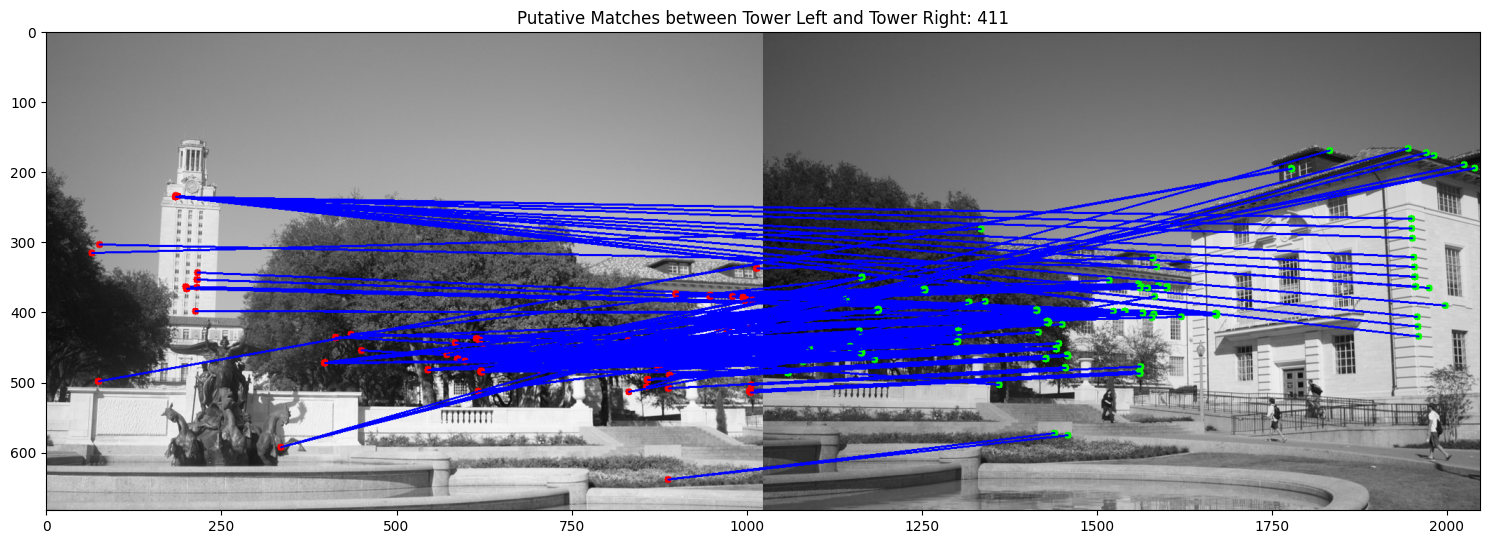

In [13]:
# Create a visualization with the actual images
# First concatenate the images horizontally
h1, w1 = tower_left.shape
h2, w2 = tower_right.shape
match_img = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
match_img[:h1, :w1] = tower_left
match_img[:h2, w1:w1+w2] = tower_right

# Convert to color for drawing
match_img_color = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR)

# Draw the matches
for match in matches:
    # Get corresponding points using queryIdx and trainIdx from the DMatch object
    x1, y1 = valid_corners_left[match.queryIdx]
    x2, y2 = valid_corners_right[match.trainIdx]
    
    # Adjust x-coordinate for right image
    x2 = x2 + w1
    
    # Draw points and line
    cv2.circle(match_img_color, (int(x1), int(y1)), 5, (0, 0, 255), -1)  # Red circle for left point
    cv2.circle(match_img_color, (int(x2), int(y2)), 5, (0, 255, 0), -1)  # Green circle for right point
    cv2.line(match_img_color, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Blue line connecting points

# Show the matches
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(match_img_color, cv2.COLOR_BGR2RGB))
plt.title(f"Putative Matches between Tower Left and Tower Right: {len(matches)}")
plt.tight_layout()
plt.show()

### Step 6
Run RANSAC to estimate (1) an affine transformation and (2) a homography mapping one image onto the other. For each transformation, report the inlier number and the average residual (squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Also, display the locations of inlier matches in both images.

In [14]:
# Convert matches to lists of points for the following 
# affine transformation and homography operations
src_pts = np.float32([valid_corners_left[m.queryIdx] for m in matches])
dst_pts = np.float32([valid_corners_right[m.trainIdx] for m in matches])

#### Estimate Affine Transformation using RANSAC

In [15]:
# Set ransacReprojThreshold to 5.0 for treating a 
# point pair as an inlier
affine_transform, affine_inliers = cv2.estimateAffinePartial2D(
    src_pts,
    dst_pts,
    method=cv2.RANSAC,
    ransacReprojThreshold=5.0
)

# Count inliers for affine transformation
num_affine_inliers = np.sum(affine_inliers)

# Calculate average residual for affine inliers
# Residual is the squared distance between the two matching 
# point coordinates
affine_inlier_idx = np.where(affine_inliers == 1)[0]
affine_residuals = []
for idx in affine_inlier_idx:
    src_pt = src_pts[idx]
    dst_pt = dst_pts[idx]
    transformed_pt = np.dot(affine_transform, np.append(src_pt, 1))
    residual = np.mean(np.sum((transformed_pt - dst_pt)**2))
    affine_residuals.append(residual)
avg_affine_residual = np.mean(affine_residuals) if affine_residuals else float("inf")

print(f"Affine Transformation:")
print(f"Inliers: {num_affine_inliers} out of {len(matches)}")
print(f"Average Residual: {avg_affine_residual:.4f}")

Affine Transformation:
Inliers: 64 out of 411
Average Residual: 2.2515


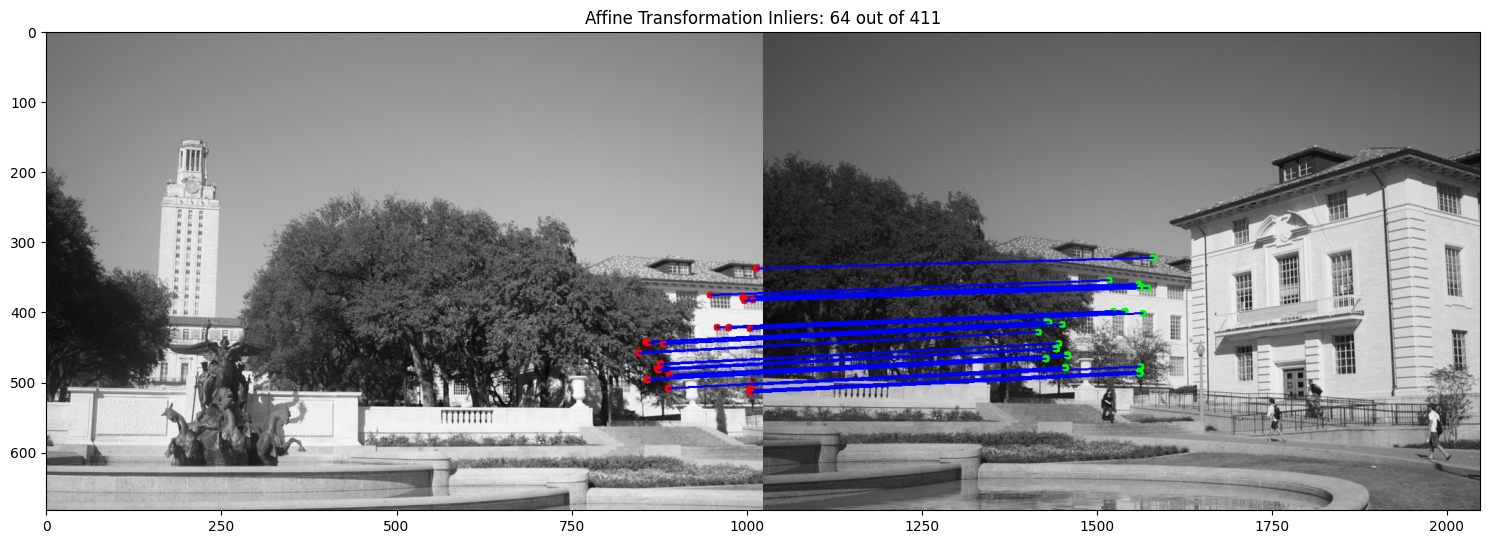

In [16]:
# Display inlier matches
# Create a side-by-side image
h1, w1 = tower_left.shape
h2, w2 = tower_right.shape
match_img = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
match_img[:h1, :w1] = tower_left
match_img[:h2, w1:w1+w2] = tower_right
match_img_color = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR)

# Draw affine transformation inliers
for idx in affine_inlier_idx:
    # Get corresponding points
    x1, y1 = src_pts[idx]
    x2, y2 = dst_pts[idx]
    
    # Adjust x-coordinate for right image
    x2 = x2 + w1
    
    # Draw points and line
    cv2.circle(match_img_color, (int(x1), int(y1)), 5, (0, 0, 255), -1)  # Red circle for left point
    cv2.circle(match_img_color, (int(x2), int(y2)), 5, (0, 255, 0), -1)  # Green circle for right point
    cv2.line(match_img_color, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Blue line connecting points

# Show the matches
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(match_img_color, cv2.COLOR_BGR2RGB))
plt.title(f"Affine Transformation Inliers: {num_affine_inliers} out of {len(matches)}")
plt.tight_layout()
plt.show()

#### Estimate homography mapping using RANSAC

In [17]:
# Set ransacReprojThreshold to 5.0 for treating a 
# point pair as an inlier
homography, homography_inliers = cv2.findHomography(
    src_pts,
    dst_pts,
    method=cv2.RANSAC,
    ransacReprojThreshold=5.0
)

# Count inliers for homography
num_homography_inliers = np.sum(homography_inliers)

# Calculate average residual for homography inliers
# Residual is the squared distance between the two matching 
# point coordinates
homography_inlier_idx = np.where(homography_inliers == 1)[0]
homography_residuals = []
for idx in homography_inlier_idx:
    src_pt = src_pts[idx]
    dst_pt = dst_pts[idx]
    
    # Convert to homogeneous coordinates
    src_pt_h = np.append(src_pt, 1).reshape(3, 1)
    
    # Apply homography
    transformed_pt_h = np.dot(homography, src_pt_h)
    
    # Convert back from homogeneous coordinates
    transformed_pt = (transformed_pt_h[:2] / transformed_pt_h[2]).reshape(2)
    residual = np.mean(np.sum((transformed_pt - dst_pt)**2))
    homography_residuals.append(residual)

avg_homography_residual = np.mean(homography_residuals) if homography_residuals else float("inf")

print(f"Homography:")
print(f"Inliers: {num_homography_inliers} out of {len(matches)}")
print(f"Average Residual: {avg_homography_residual:.4f}")

Homography:
Inliers: 79 out of 411
Average Residual: 2.0529


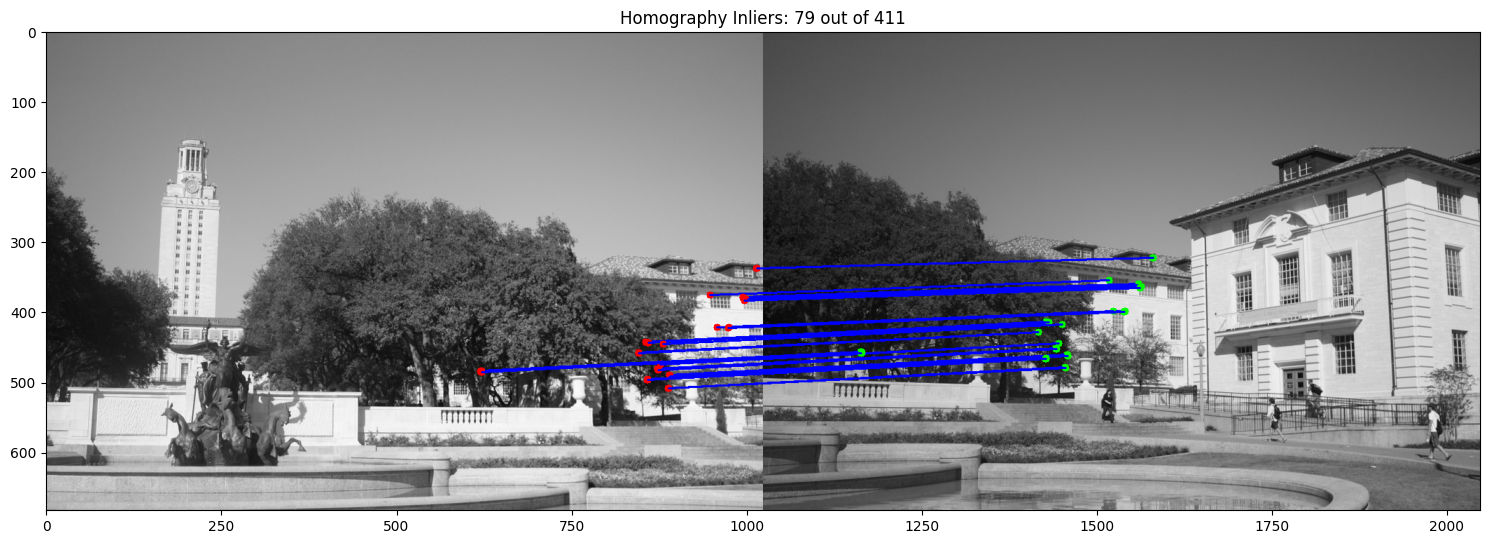

In [18]:
# Display inlier matches
# Create a side-by-side image
h1, w1 = tower_left.shape
h2, w2 = tower_right.shape
match_img = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
match_img[:h1, :w1] = tower_left
match_img[:h2, w1:w1+w2] = tower_right
match_img_color = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR)

# Draw homography inliers
for idx in homography_inlier_idx:
    # Get the corresponding points
    x1, y1 = src_pts[idx]
    x2, y2 = dst_pts[idx]
    
    # Adjust x-coordinate for the right image
    x2 = x2 + w1
    
    # Draw feature points and lines for matches
    cv2.circle(match_img_color, (int(x1), int(y1)), 5, (0, 0, 255), -1)
    cv2.circle(match_img_color, (int(x2), int(y2)), 5, (0, 255, 0), -1)
    cv2.line(match_img_color, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

# Show the matches
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(match_img_color, cv2.COLOR_BGR2RGB))
plt.title(f"Homography Inliers: {num_homography_inliers} out of {len(matches)}")
plt.tight_layout()
plt.show()

In [19]:
def stitch_two_images(img1, img2, H, inv=False):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    # Use the inverse homography if flag is set to True
    transform_matrix = np.linalg.inv(H) if inv else H
    
    # Calculate the corners of img1
    corners = np.array([[0, 0, 1], [0, h1-1, 1], [w1-1, h1-1, 1], [w1-1, 0, 1]], dtype=np.float32)
    
    # Transform corners
    transformed_corners = []
    for corner in corners:
        tc = np.dot(transform_matrix, corner)
        tc = tc / tc[2]  # Normalize homogeneous coordinates
        transformed_corners.append(tc[:2])
    
    transformed_corners = np.array(transformed_corners)
    
    # Calculate bounds
    min_x = min(0, np.min(transformed_corners[:, 0]))
    max_x = max(w2, np.max(transformed_corners[:, 0]))
    min_y = min(0, np.min(transformed_corners[:, 1]))
    max_y = max(h2, np.max(transformed_corners[:, 1]))
    
    # Create output canvas
    width = int(max_x - min_x + 0.5)
    height = int(max_y - min_y + 0.5)
    
    # Create translation matrix
    translation = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ])
    
    # Combine matrices
    full_transform = translation @ transform_matrix
    
    # Warp img1
    warped_img1 = cv2.warpPerspective(img1, full_transform, (width, height))
    
    # Place img2 with translation
    result = np.zeros((height, width), dtype=np.uint8)
    x_offset = int(-min_x) if min_x < 0 else 0
    y_offset = int(-min_y) if min_y < 0 else 0
    
    # Make sure to not go out of bounds
    if y_offset + h2 <= height and x_offset + w2 <= width:
        result[y_offset:y_offset+h2, x_offset:x_offset+w2] = img2
    
    # Create masks for blending
    mask1 = warped_img1 > 0
    mask2 = result > 0
    overlap = mask1 & mask2
    
    # Blend in the overlap region
    blended = result.copy()
    blended[mask1 & ~mask2] = warped_img1[mask1 & ~mask2]  # Non-overlapping parts of img1
    blended[overlap] = ((warped_img1[overlap].astype(np.float32) + 
                         result[overlap].astype(np.float32)) / 2).astype(np.uint8)
    
    return blended, warped_img1, result

panorama, warped, right = stitch_two_images(tower_right, tower_left, homography, inv=True)

### Step 7
Warp one image onto the other using the estimated transformation.
- Note: Results of homography were used as this resulted in more inlier matches especially in the two similar buildings (i.e. building on the right in `tower_left.jpg` and the building on the middle in `tower_right.jpg`).

In [23]:
def stitch_two_images(img1, img2, H, inv=False):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    # Use the inverse homography if specified
    transform_matrix = np.linalg.inv(H) if inv else H
    
    # Calculate the corners of img1
    corners = np.array([[0, 0, 1], [0, h1-1, 1], [w1-1, h1-1, 1], [w1-1, 0, 1]], dtype=np.float32)
    
    # Transform corners
    transformed_corners = []
    for corner in corners:
        tc = np.dot(transform_matrix, corner)
        tc = tc / tc[2]  # Normalize homogeneous coordinates
        transformed_corners.append(tc[:2])
    
    transformed_corners = np.array(transformed_corners)
    
    # Calculate bounds
    min_x = min(0, np.min(transformed_corners[:, 0]))
    max_x = max(w2, np.max(transformed_corners[:, 0]))
    min_y = min(0, np.min(transformed_corners[:, 1]))
    max_y = max(h2, np.max(transformed_corners[:, 1]))
    
    # Create output canvas
    width = int(max_x - min_x + 0.5)
    height = int(max_y - min_y + 0.5)
    
    # Create translation matrix
    translation = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ])
    
    # Combine matrices
    full_transform = translation @ transform_matrix
    
    # Warp img1
    warped_img1 = cv2.warpPerspective(img1, full_transform, (width, height))
    
    # Place img2 with translation
    result = np.zeros((height, width), dtype=np.uint8)
    x_offset = int(-min_x) if min_x < 0 else 0
    y_offset = int(-min_y) if min_y < 0 else 0
    
    # Make sure we don't go out of bounds
    if y_offset + h2 <= height and x_offset + w2 <= width:
        result[y_offset:y_offset+h2, x_offset:x_offset+w2] = img2
    
    # Create masks for blending
    mask1 = warped_img1 > 0
    mask2 = result > 0
    overlap = mask1 & mask2
    
    # Blend in the overlap region
    panorama = result.copy()
    panorama[mask1 & ~mask2] = warped_img1[mask1 & ~mask2]  # Non-overlapping parts of img1
    panorama[overlap] = ((warped_img1[overlap].astype(np.float32) + 
                         result[overlap].astype(np.float32)) / 2).astype(np.uint8)
    
    return panorama, warped_img1, result

# Use the inverse of the homography matrix as this results 
# in a better final stitch of the two images
panorama, warped, right = stitch_two_images(tower_right, tower_left, homography, inv=True)

### Step 8
Create a new image big enough to hold the panorama and composite the two images into it. You can composite by simply averaging the pixel values where the two images overlap. Write the composite image to a file called stitched_output.jpg.

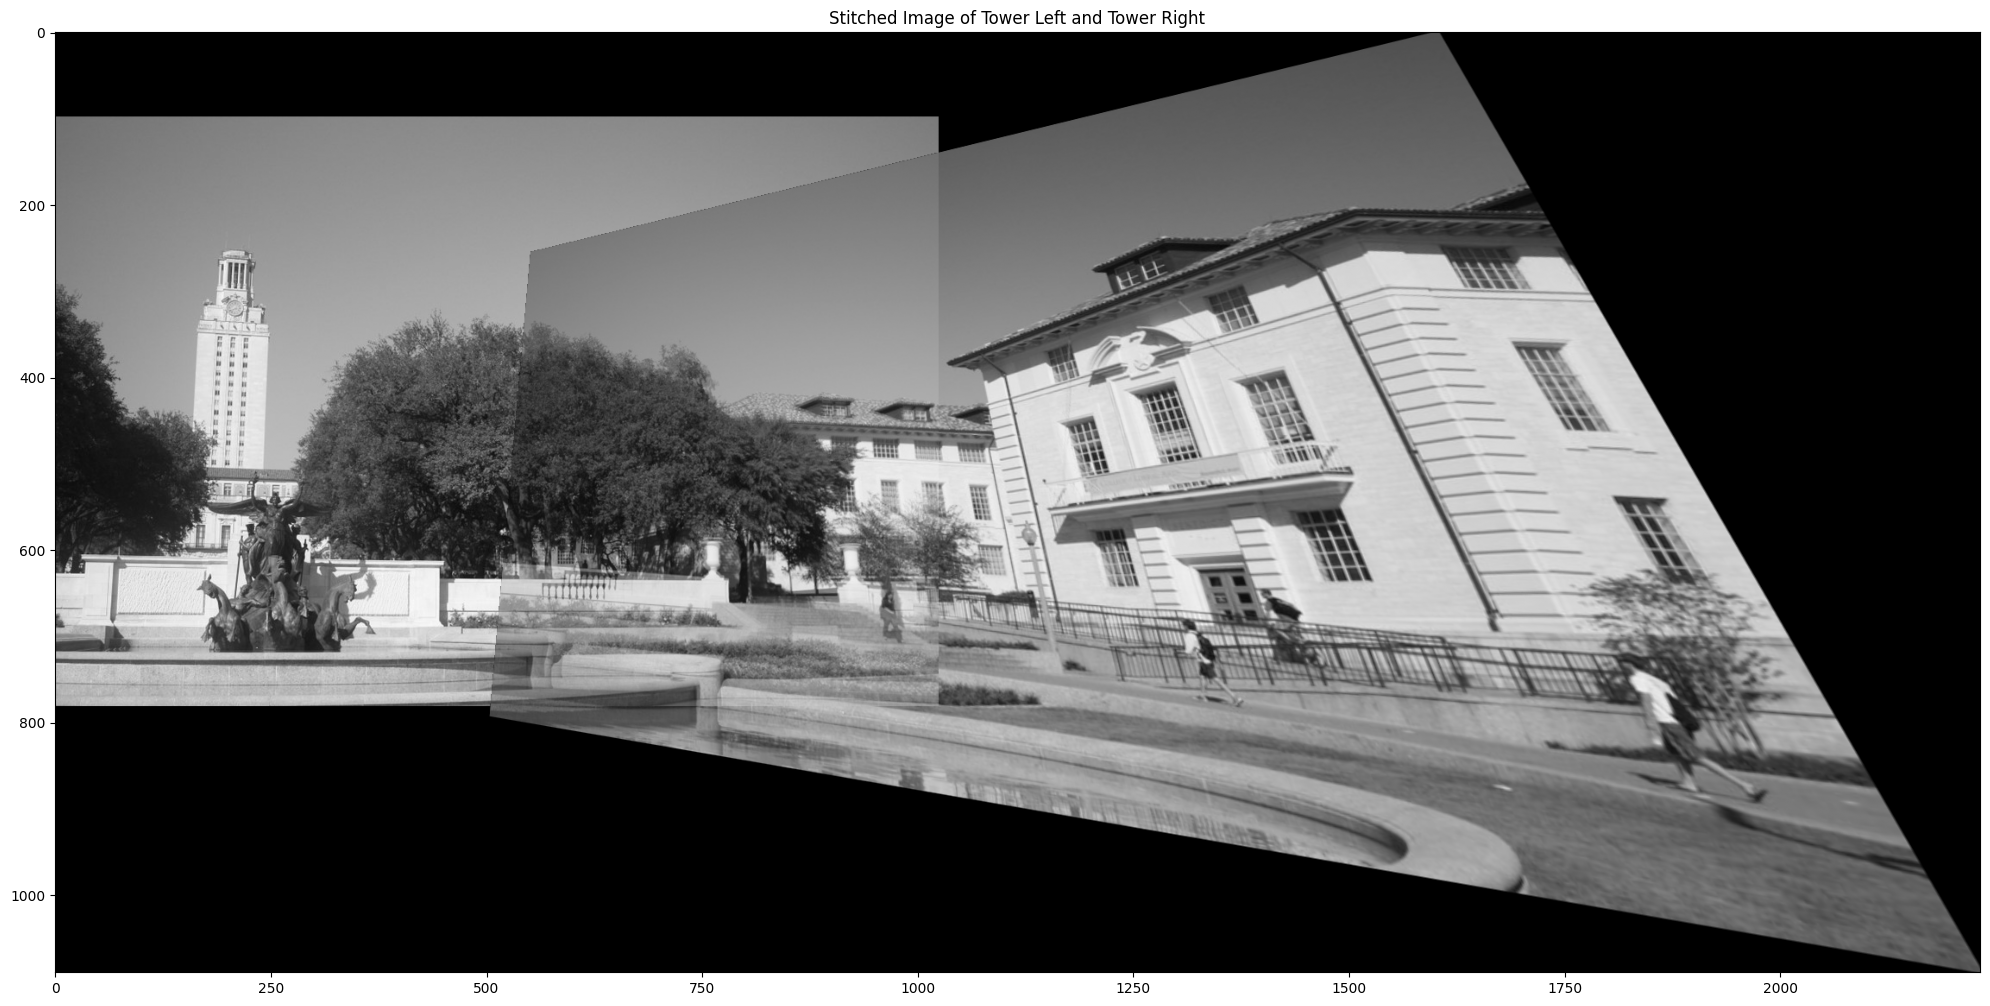

True

In [24]:
# Display the results of stitching from previous step
plt.figure(figsize=(20, 12))
plt.imshow(panorama, cmap="gray"), plt.title("Stitched Image of Tower Left and Tower Right")
plt.tight_layout()
plt.show()

cv2.imwrite("stitched_output.jpg", panorama)